In [1]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter
import skimage
from skimage.transform import rescale
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import norm, gaussian_kde
import time as time
import geopandas as gpd
import pandas as pd

def get_extent(shpfile):
    df = gpd.read_file(shp).to_crs("EPSG:4326")
    df = df[df.area==np.max(df.area)].reset_index()
    xmin, ymin, xmax, ymax = df.bounds.values[0]
    extent = [-xmax, -xmin, ymin,ymax]
    return(extent)

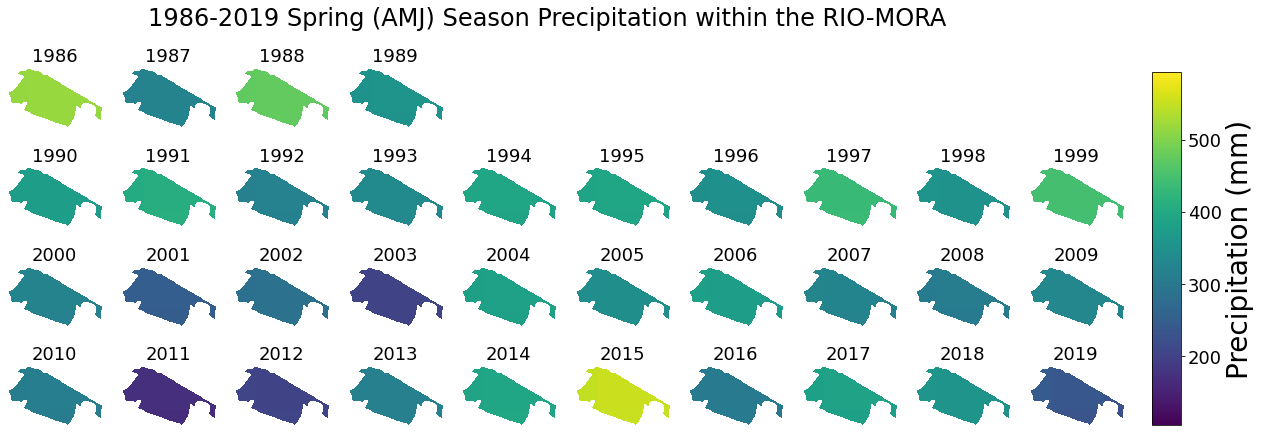

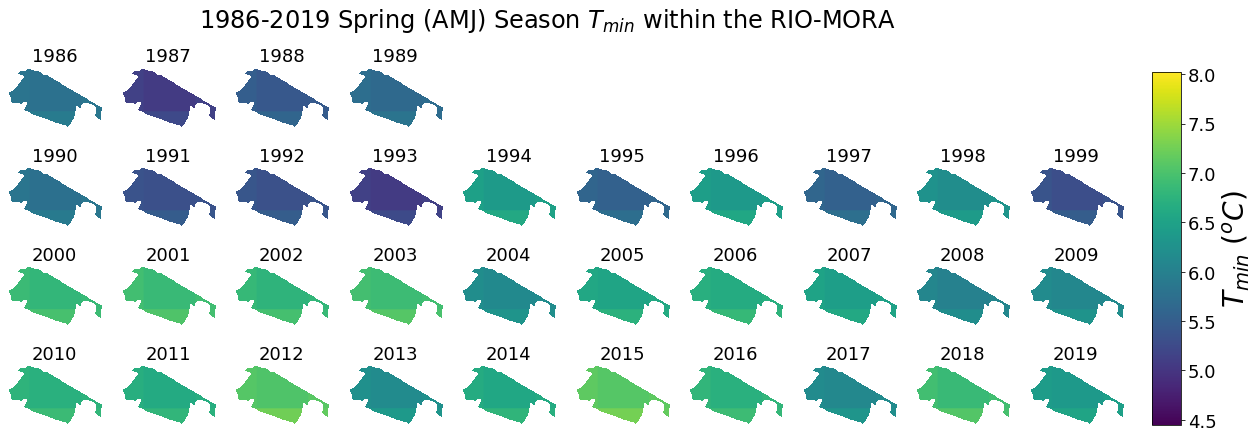

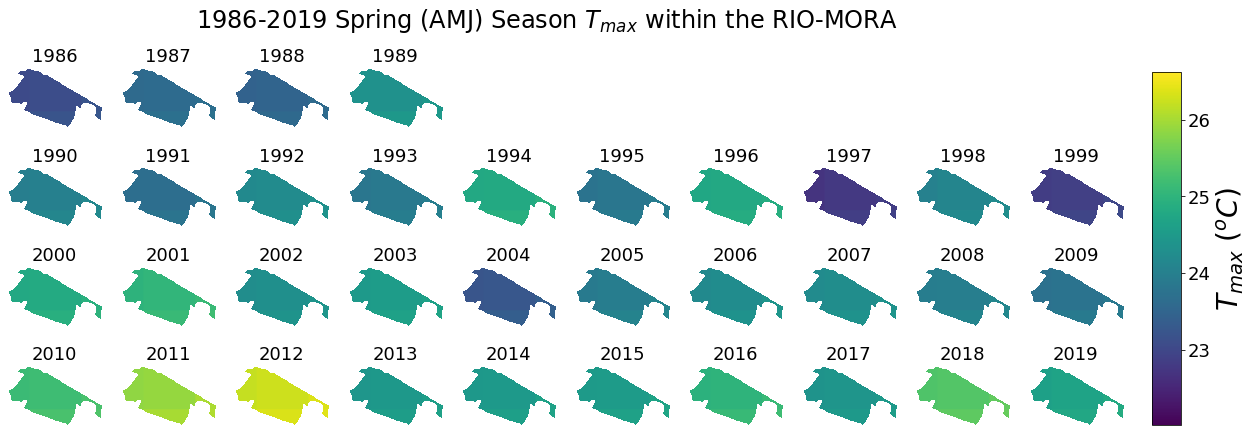

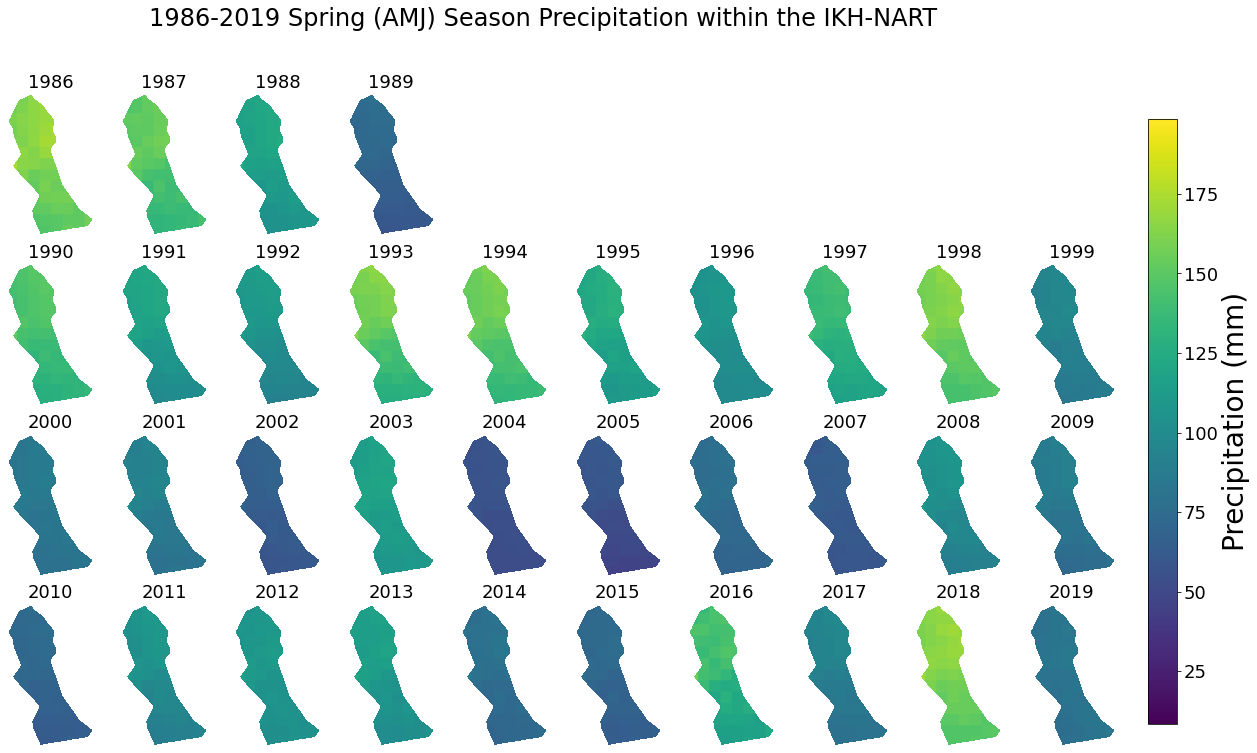

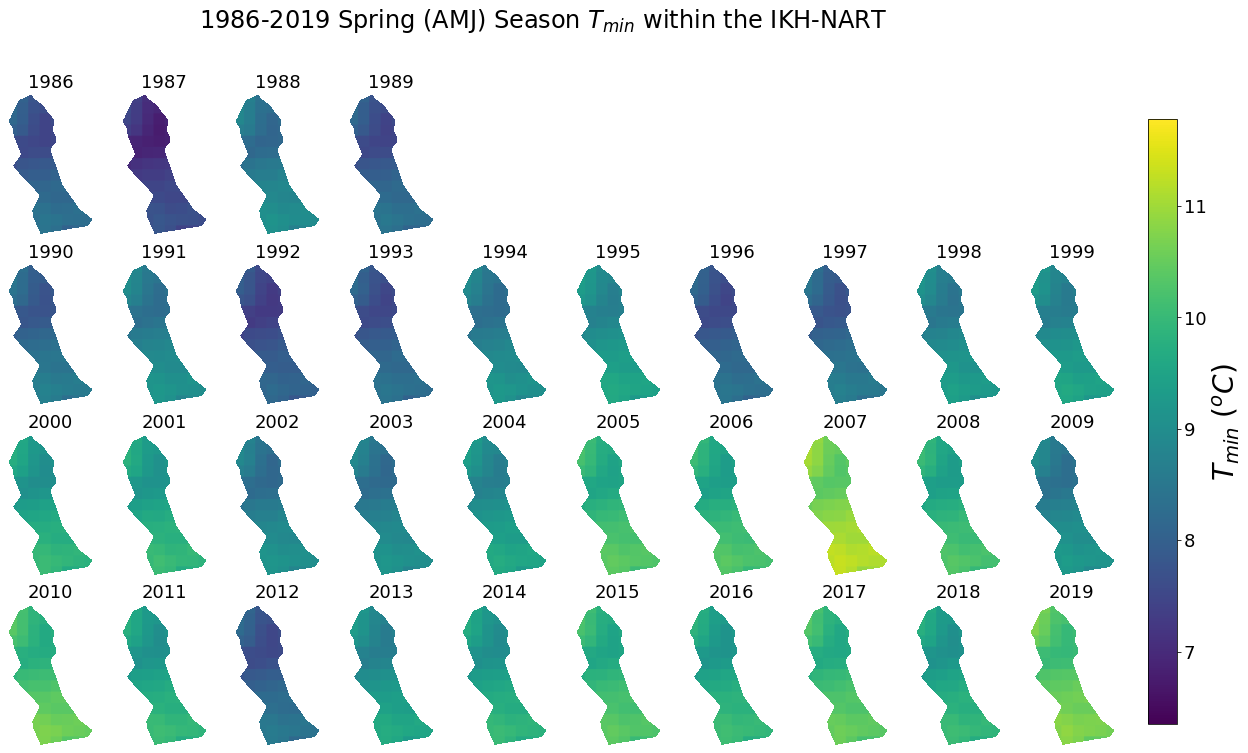

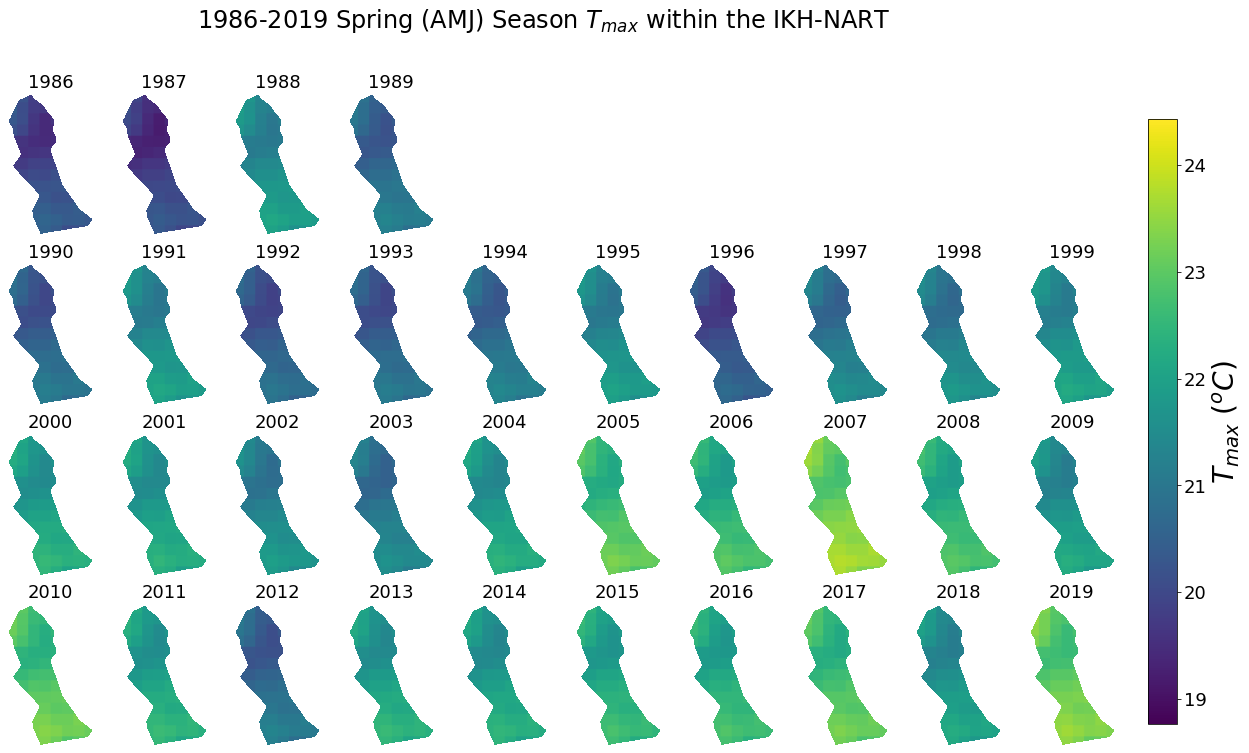

In [62]:
BUCKETS = ['rio-mora','ikh-nart']
for BUCKET in BUCKETS:
    ####NDVI DATA PREP####
    tif = rasterio.open(f'/datadrive/{BUCKET}/processed/TERRA_AMJ.tif')
    terra = tif.read()
    if BUCKET == 'ikh-nart':
        shp = './data/shp/IN_boundary/IN_boundary.shp'
        figsize = (20,12)
        n_clusters = 3
    else:
        shp = './data/shp/RioMoraNWRBndry_2019/RioMoraNWRBndry_2019.shp'
        figsize = (20,7)
        n_clusters = 3
    labels = ['Precipitation', '$T_{min}$', '$T_{max}$']
    unit = ['(mm)', '$(^oC)$', '$(^oC)$']
    selection =['pr','n','x']
    for n in range(len(selection)):
        var = selection[n]

        cindex = [(i+1,b) for i,b in enumerate(tif.descriptions) \
                  if any(s in b for s in var)]
        data = np.array([tif.read(c[0]) for c in cindex])
        if var == 'pr':
            scale = 1
        else:
            scale = 0.1
        data = scale*data
        vmin = np.nanmean(data)-(3*np.nanstd(data))
        vmax = np.nanmean(data)+(3*np.nanstd(data))

        years = np.arange(1986,2020) 
        max_year_i = np.argmax(np.nanmean(data,axis=(1,2)))
        min_year_i = np.argmin(np.nanmean(data,axis=(1,2)))
        decade_map = {'198':0, '199':1, '200':2, '201':3}

        ####GRIDSPEC PREP####
        fig = plt.figure(figsize=figsize, facecolor='white')
        gs = GridSpec(2, 4, wspace=0, hspace=0.05)
        rows, cols = 4,10
        gs0 = GridSpecFromSubplotSpec(rows, cols, subplot_spec=gs[:,:])

        row_group = []
        for k,v in decade_map.items():
            for y in years:
                if k in str(y):
                    row_group.append(v)
        row_group = np.array(row_group)            

        col_group = []
        u,c = np.unique(row_group, return_counts=True)
        for j in c:
            col_group.append(np.arange(j))
        col_group = np.concatenate(col_group)

        ####NDVI PLOT####
        for i in range(len(data)):            
            r, c = row_group[i], col_group[i]
            ax = fig.add_subplot(gs0[r,c])   
            ax.axis('off')
            ax.imshow(data[i],vmin=vmin,vmax=vmax)
            ax.set_title(years[i],fontsize=18)

        fig.suptitle(f'1986-2019 Spring (AMJ) Season {labels[n]} within the {BUCKET.upper()}', fontsize=24)
        cmap = mpl.cm.viridis
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        cb = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm)
        cb.ax.tick_params(labelsize=18) 
        cb.set_label(f'{labels[n]} {unit[n]}', fontsize=28)
        fig.savefig(f'./figs/{BUCKET}_AMJ_{labels[n]}.png',\
                  dpi=300, bbox_inches='tight')
        fig.show()


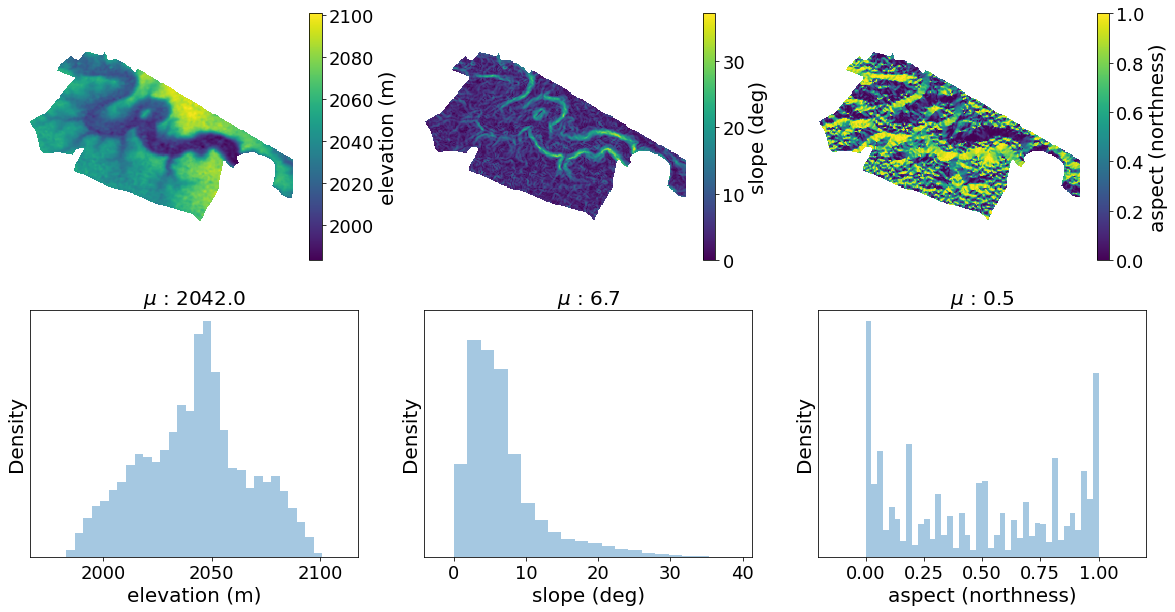

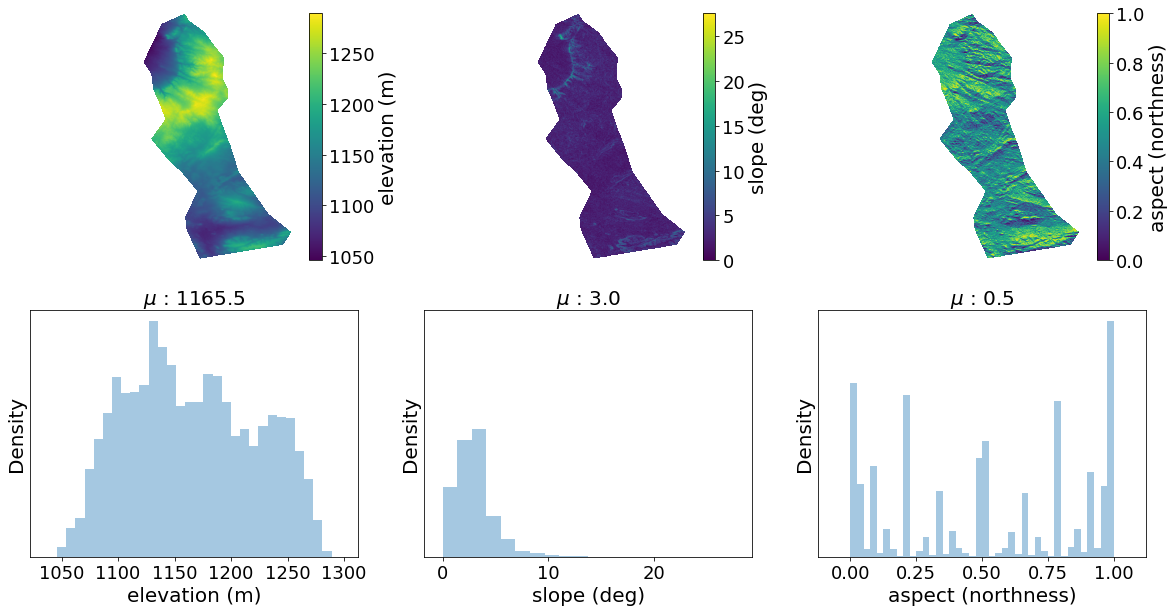

In [38]:
BUCKETS = ['rio-mora','ikh-nart']
for BUCKET in BUCKETS:
    ####NDVI DATA PREP####
    tif = rasterio.open(f'/datadrive/{BUCKET}/processed/ndvi.tif')
    ndvi = tif.read()
    tif = rasterio.open(f'/datadrive/{BUCKET}/processed/srtm.tif')
    srtm = tif.read()
    var = srtm[0].copy()
    if BUCKET == 'ikh-nart':
        vmin = 0.1
        vmax = 0.35
        shp = './data/shp/IN_boundary/IN_boundary.shp'
        figsize = (20,12)
        n_clusters = 3
        smoothed_rescale = rescale(gaussian_filter(var.copy(), sigma=2), 0.3, mode='reflect')
    else:
        shp = './data/shp/RioMoraNWRBndry_2019/RioMoraNWRBndry_2019.shp'
        vmin = 0.2
        vmax = 0.65
        figsize = (20,7)
        n_clusters = 3
        smoothed_rescale = rescale(var.copy(), 0.75, mode='reflect')

    labels = ['elevation (m)', 'slope (deg)', 'aspect (northness)']
    nbins = [30,20,40]
    f, ax = plt.subplots(2,3,figsize=(20,10))
    for i,d in enumerate(srtm):
        if i ==2:
            d = ne_transform(d)
        cmap = plt.cm.viridis
        im = ax[0,i].imshow(d, cmap=cmap)
        ax[0,i].axis('off')
        cbar = f.colorbar(im, ax=ax[0,i])
        cbar.ax.set_ylabel(labels[i], fontsize=20)
        cbar.ax.tick_params(labelsize=18) 
        #ax[1,i].hist(d.flatten(),bins=8)
        #kde_kws={'color':'blue','lw':1,'ls':'--','alpha':1},

        #minbin, maxbin = np.nanmin(d), np.nanmax(d)
        #bins = np.linspace(minbin, maxbin, nbins[i])
        #cbins = (bins-bins.min())/(bins.max()-bins.min())
        #hist, bin_edges = np.histogram(d, bins)
        #colors = cmap(cbins)
        #width = bins[1]-bins[0]
        #ax[1,i].bar(bin_edges[:-1], hist, width=width, color=colors)
        ax[1,i].set_xlabel(labels[i], fontsize=20)
        ax[1,i].set_yticks([])
        ax[1,i].set_ylabel('Density', fontsize=20)
        ax[1,i].tick_params(axis='both', labelsize=18)
        sns.distplot(d.flatten(), ax=ax[1,i], hist=True, bins=nbins[i],
                 kde=True, kde_kws={'lw':0})#,\
                 #fit=norm, fit_kws={'lw':2,'ls':'--',"alpha": 0.9, "color": "k"})
        ax[1,i].set_title('$\mu$ : %0.1f'%np.nanmean(d.flatten()),fontsize=20)


Compute structured hierarchical clustering...
Elapsed time:  1.9415967464447021
Number of pixels:  28696
Number of clusters:  3
Compute structured hierarchical clustering...
Elapsed time:  20.332008600234985
Number of pixels:  210504
Number of clusters:  3
{'rio-mora': {'0_med': 2046.3572, '0_sd': 19.979156, '2_med': 2004.4188, '2_sd': 10.637642}, 'ikh-nart': {'0_med': 1200.4116, '0_sd': 53.861862, '2_med': 1128.5455, '2_sd': 29.839779}}


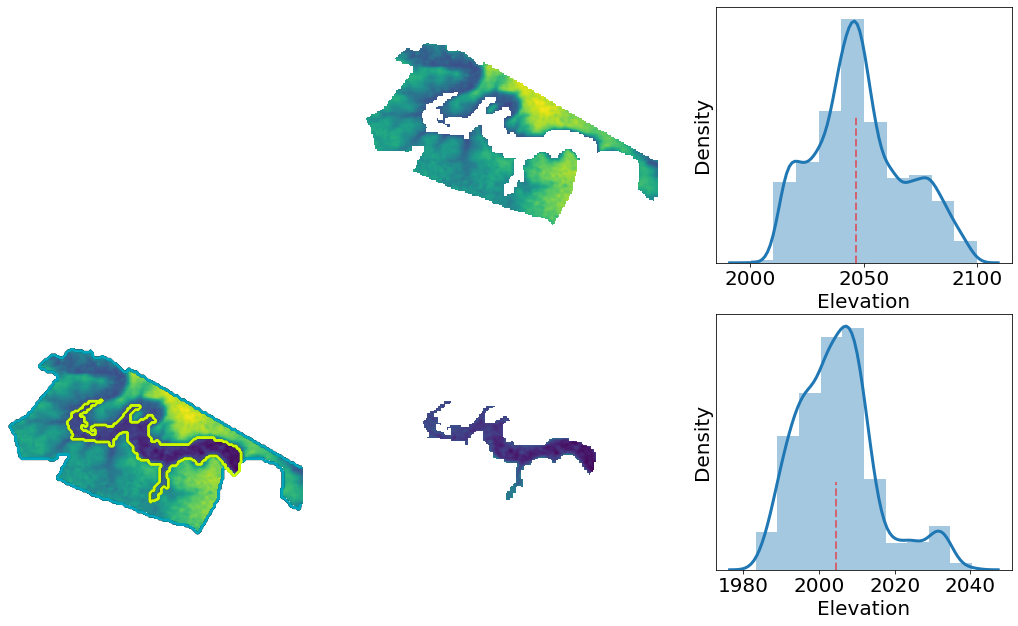

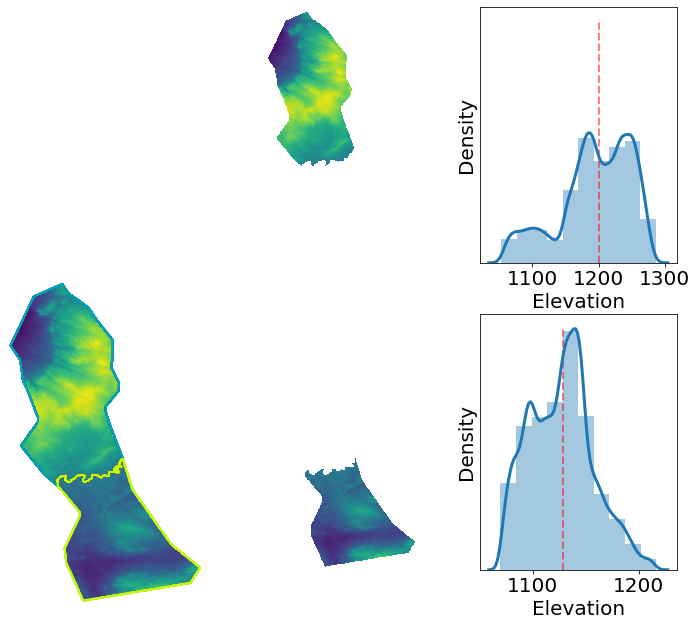

In [3]:
####SUMMARY PLOT!####
#create map highlighting the spatial regions of differing elevation groups
#use cluster analysis?

BUCKETS = ['rio-mora','ikh-nart']
topo_var = ['elevation', 'slope', 'aspect']
cluster_stats = {} 
for BUCKET in BUCKETS:
    ####NDVI DATA PREP####
    tif = rasterio.open(f'/datadrive/{BUCKET}/processed/ndvi.tif')
    ndvi = tif.read()
    tif = rasterio.open(f'/datadrive/{BUCKET}/processed/srtm.tif')
    srtm = tif.read()
    var = srtm[0].copy()
    if BUCKET == 'ikh-nart':
        vmin = 0.1
        vmax = 0.35
        shp = './data/shp/IN_boundary/IN_boundary.shp'
        figsize = (12,16)
        n_clusters = 3
        smoothed_rescale = rescale(gaussian_filter(var.copy(), sigma=2), 0.3, mode='reflect')
    else:
        shp = './data/shp/RioMoraNWRBndry_2019/RioMoraNWRBndry_2019.shp'
        vmin = 0.2
        vmax = 0.65
        figsize = (18,16)
        n_clusters = 3
        smoothed_rescale = rescale(var.copy(), 0.75, mode='reflect')
    #extent = get_extent(shp)
    ###############################################################################
    # Cluster analysis
    smoothed_rescale[np.isnan(smoothed_rescale)]=-1
    X = np.reshape(smoothed_rescale, (-1,1))
    connectivity = grid_to_graph(*smoothed_rescale.shape)
    print("Compute structured hierarchical clustering...")
    
    st = time.time()
    ward = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward',
                                   connectivity=connectivity)
    ward.fit(X)
    label = np.reshape(ward.labels_, smoothed_rescale.shape)
    print("Elapsed time: ", time.time() - st)
    print("Number of pixels: ", label.size)
    print("Number of clusters: ", np.unique(label).size)
    img = smoothed_rescale.copy()
    vmin,vmax = np.nanmin(var), np.nanmax(var)
    img[img==-1] = np.nan
    # #############################################################################
    # Plot the results on an image
    fig = plt.figure(figsize=figsize, facecolor='white')
    gs = GridSpec(3, 3)
    rows, cols = 3,2
    ax = fig.add_subplot(gs[:,0])   
    ax.imshow(img, vmin=vmin, vmax=vmax)
    #plt.imshow(smoothed_rescale, cmap=plt.cm.gray)
    for l in range(n_clusters):
        ax.contour(label == l,
                    colors=[plt.cm.nipy_spectral(l / float(n_clusters)), ])
    ax.axis('off')    
    
    gs0 = GridSpecFromSubplotSpec(rows, cols, subplot_spec=gs[:,1:])
    
    labelcounts = [np.sum(label==i) for i in range(n_clusters)]
    
    counter = 0
    cluster_stats[BUCKET] = {} 
    for i in range(n_clusters):
        if i != np.argmax(labelcounts):
            ax0 = fig.add_subplot(gs0[counter,0])   
            mask = ~(label==i)
            out = np.ma.MaskedArray(img,mask=mask)
            nbins=10
            ax0.imshow(out, vmin=vmin, vmax=vmax)
            ax0.axis('off')
            ax1 = fig.add_subplot(gs0[counter,1])   
            sns.distplot(img[label==i], ax=ax1, hist=True, bins=nbins,\
                         kde=True, kde_kws={'lw':3})
            cluster_stats[BUCKET].update({f'{i}_med':np.median(img[label==i]),f'{i}_sd':np.std(img[label==i])})
            ax1.vlines(np.median(img[label==i]),ymin=0, ymax=0.015,\
                                 alpha=0.5, ls='--', lw=2, color='r')
            ax1.set_yticks([])
            ax1.set_ylabel('Density', fontsize=20)
            ax1.set_xlabel('Elevation', fontsize=20)
            ax1.tick_params(axis='both', labelsize=20)
            counter+=1
#now compute the elevational clusters draw the time series of the NDVI
#larger or smaller than the median of the zones
print(cluster_stats)

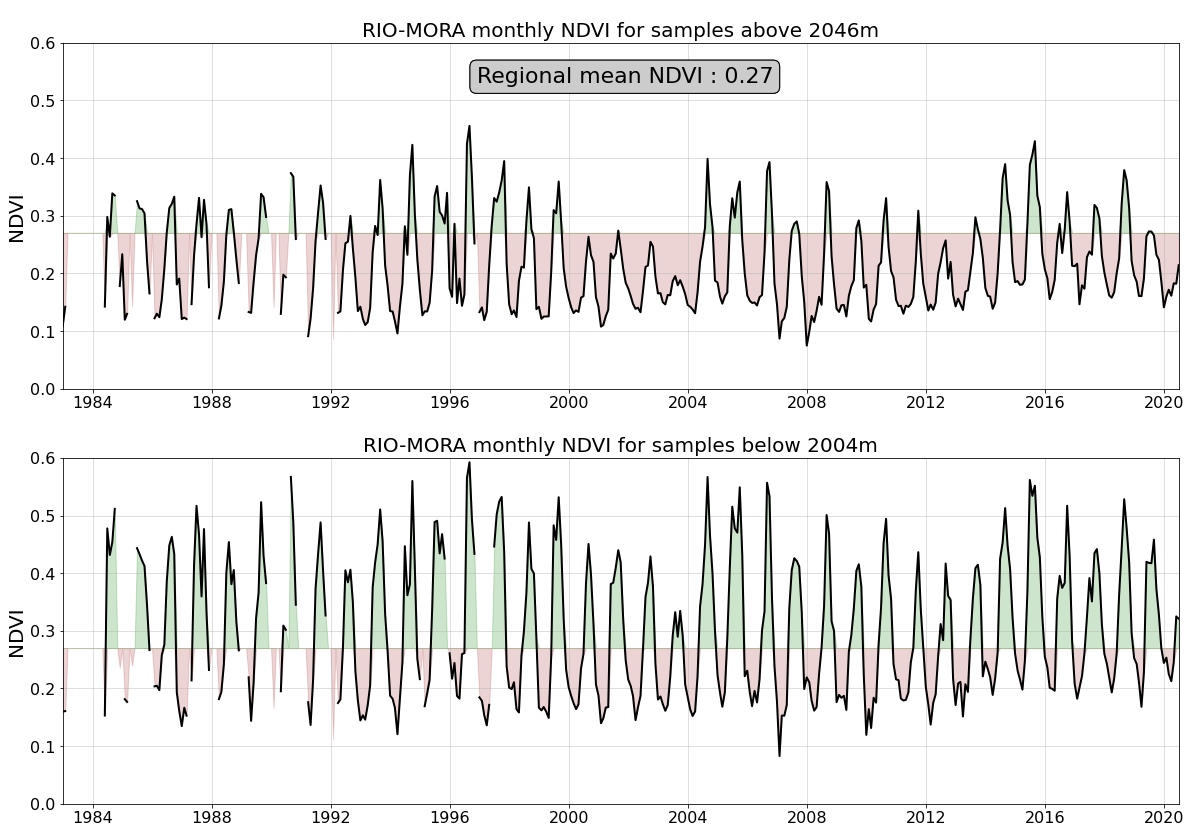

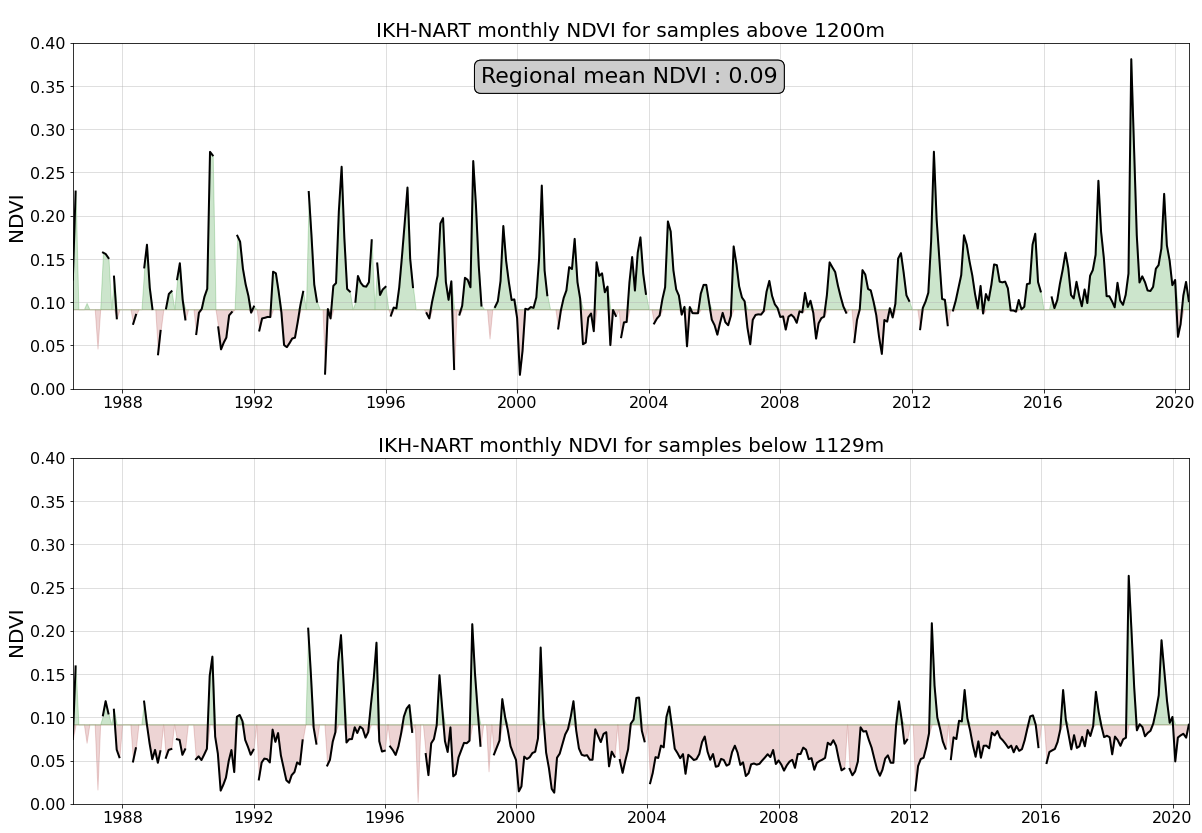

In [39]:
####VI PLOTS ONLY#####
vi = 'ndvi'
BUCKETS = ['rio-mora', 'ikh-nart']
for BUCKET in BUCKETS:
    if BUCKET=='ikh-nart':
        alias = 'wdpa-99848'
        tif = rasterio.open(f'/datadrive/{BUCKET}/processed/{vi}.tif')
        landsatfile = f'/datadrive/{BUCKET}/data/{alias}/LANDSAT_NDVI_EVI_{alias}_v1_long_2020-06-01.csv'
        ndvi = gpd.read_file(landsatfile)
        if vi == 'evi':
            vmin = 0.1
            vmax = 0.55 
        else:
            vmin = 0.1
            vmax = 0.35
            ymin = 0
            ymax = 0.4
        figsize = (16,12)
    if BUCKET=='rio-mora':
        alias = 'wdpa-555609346'
        tif = rasterio.open(f'/datadrive/{BUCKET}/processed/{vi}.tif')
        landsatfile = f'/datadrive/{BUCKET}/data/{alias}/LANDSAT_NDVI_EVI_{alias}_v1_long_2020-06-02.csv'
        ndvi = gpd.read_file(landsatfile)
        if vi == 'evi':
            vmin = 0.2
            vmax = 1.75 
        else:
            vmin = 0.2
            vmax = 0.65
            ymin = 0
            ymax = 0.6 
        figsize = (16,8)
    ndvi_data = tif.read()
    srtm_tif = rasterio.open(f'/datadrive/{BUCKET}/processed/srtm.tif')
    srtm = srtm_tif.read()
    var = srtm[0].copy()
    if BUCKET=='ikh-nart':
        elev = srtm[0].copy()[:-1,:]
    else:
        elev = srtm[0].copy()[:-1,:]
    medians = np.array([v for k,v in cluster_stats[BUCKET].items() if 'med' in k])

    #hi_mask = elev>=np.nanmax(medians)
    #lo_mask = elev<=np.nanmin(medians)

    #hi_ndvi = np.array([np.nanmean(d[hi_mask]) for d in ndvi_data])
    #lo_ndvi = np.array([np.nanmean(d[lo_mask]) for d in ndvi_data])
    
    #plt.imshow(np.ma.MaskedArray(elev, mask=~hi_mask))
    #plt.imshow(np.ma.MaskedArray(elev, mask=~lo_mask))
    #plt.imshow(elev<=np.nanmin(medians))
    #plt.plot(hi_ndvi)
    #plt.plot(np.nanmean(ndvi, axis=(1,2)))
    #plt.plot(lo_ndvi)
    ###############################
    #LOAD THE POINT DATA
    points = gpd.read_file(f'/datadrive/{BUCKET}/data/{alias}/{alias}_points_v1.csv')
    elev = gpd.read_file(f'/datadrive/{BUCKET}/data/{alias}/GLOBAL_ELEVATION_{alias}_v1.csv')
    ndvi.index = pd.to_datetime(ndvi.img_date)
    ndvi['NDVI'] = ndvi['NDVI'].astype('float')
    ndvi['EVI'] = ndvi['EVI'].astype('float')
    ndvi_mean = np.mean(ndvi.NDVI)
    
    #MAIN QUERIES HERE
    hi_query = elev[elev.elevation.astype('float')>=medians.max()]
    lo_query = elev[elev.elevation.astype('float')<=medians.min()]
    med_label = ['above %0.0fm'%medians.max(), 'below %0.0fm'%medians.min()] 
    f, ax = plt.subplots(2,1,figsize=(20,14),facecolor='white')
    queries = [hi_query, lo_query]
    for i, q in enumerate(queries):
        ndvi_query = ndvi.merge(q, on='loc_id',how='inner')
        ndvi_query.index = pd.to_datetime(ndvi_query.img_date)
        ndvi_query = ndvi_query[['EVI','NDVI']]
        ndvi_mu = ndvi_query.groupby(ndvi_query.index).agg('median')
        ndvi_mu.index = pd.to_datetime(ndvi_mu.index)
        enddate='20200602'
        ts ='1m'
        ndvi_resample = ndvi_mu.resample(ts).median()
        ndvi_resample['abv'] = ndvi_resample['NDVI']
        ndvi_resample['bel'] = ndvi_resample['NDVI']

        ndvi_resample.abv[ndvi_resample.abv<ndvi_mean] = ndvi_mean
        ndvi_resample.bel[ndvi_resample.bel>ndvi_mean] = ndvi_mean
        ndvi_resample.bel[np.isnan(ndvi_resample.bel)] = ndvi_mean
        ndvi_resample.abv[np.isnan(ndvi_resample.abv)] = ndvi_mean

        ax[i].plot(ndvi_resample.index, ndvi_resample['NDVI'], \
                   color='black', lw=2)
        ax[i].fill_between(ndvi_resample.index, \
                           ndvi_mean, \
                           ndvi_resample['bel'], color='brown', alpha=0.2)
        ax[i].fill_between(ndvi_resample.index, \
                           ndvi_mean, \
                           ndvi_resample['abv'], color='green', alpha=0.2)
        ax[i].grid(alpha=0.5)
        ax[i].tick_params(axis='both', labelsize=16)
        ax[i].set_ylabel('NDVI', fontsize=20)
        ax[i].set_ylim([ymin, ymax])
        ax[i].set_xlim(left=ndvi_resample.index[0],right=ndvi_resample.index[-1])
        ax[i].set_title(f'{BUCKET.upper()} monthly NDVI for samples {med_label[i]}', fontsize=20)
        ax[i].annotate("Regional mean NDVI : %0.2f"%(ndvi_mean), xy=(0.4, 0.9), \
                       bbox=dict(boxstyle="round", fc="0.8", ec="k"),
                       xycoords='figure fraction', fontsize=22)
        #f.suptitle(f'{BUCKET.upper()} NDVI and drought anomaly time-series',\ 

In [ ]:
####SUMMARY PLOT!####

BUCKETS = ['rio-mora','ikh-nart']
for BUCKET in BUCKETS:
    ####NDVI DATA PREP####
    tif = rasterio.open(f'/datadrive/{BUCKET}/processed/ndvi.tif')
    if BUCKET == 'ikh-nart':
        vmin = 0.1
        vmax = 0.35
        figsize = (20,12)
    else:
        vmin = 0.2
        vmax = 0.65
        figsize = (20,7)

    data = tif.read()
    years = np.arange(1986,2021) 
    max_year_i = np.argmax(np.nanmean(data,axis=(1,2)))
    min_year_i = np.argmin(np.nanmean(data,axis=(1,2)))
    decade_map = {'198':0, '199':1, '200':2, '201':3}

    ####GRIDSPEC PREP####
    fig = plt.figure(figsize=figsize, facecolor='white')
    gs = GridSpec(2, 5, wspace=0, hspace=0.05)
    rows, cols = 4,10
    gs0 = GridSpecFromSubplotSpec(rows, cols, wspace=0, hspace=0.05, subplot_spec=gs[:,:-2])

    row_group = []
    for k,v in decade_map.items():
        for y in years:
            if k in str(y):
                row_group.append(v)
    row_group = np.array(row_group)            

    col_group = []
    u,c = np.unique(row_group, return_counts=True)
    for j in c:
        col_group.append(np.arange(j))
    col_group = np.concatenate(col_group)

    ####NDVI PLOT####
    for i in range(len(data)-1):            
        r, c = row_group[i], col_group[i]
        ax = fig.add_subplot(gs0[r,c])   
        ax.axis('off')
        ax.imshow(data[i],vmin=vmin,vmax=vmax)
        ax.set_title(years[i],fontsize=18)

    ####LAST YEAR PLOT####
    gs1 = GridSpecFromSubplotSpec(3,4, wspace=0, hspace=0.05, subplot_spec=gs[:,-2:])
    ax = fig.add_subplot(gs1[:-1,:2])
    ax.axis('off')
    ax.imshow(data[-1],vmin=vmin,vmax=vmax)
    ax.set_title(years[-1],fontsize=18)

    ####TRUE COLOR PREP####
    if BUCKET == 'ikh-nart':
        gamma = .5 
    else:
        gamma = .8 
    tiffile = f'/datadrive/{BUCKET}/processed/peakcolor.tif'
    tif = rasterio.open(tiffile)

    selection =['B3','B2','B1']
    colors = [(i+1,b) for i,b in enumerate(tif.descriptions) \
              if any(s in b for s in selection)]

    scale = gamma/1800
    tc_data = []
    for year in years:
        year_color = [(i,a) for i,a in colors if str(year) in a]
        r = tif.read(year_color[0][0]).astype(np.float)*scale
        g = tif.read(year_color[1][0]).astype(np.float)*scale
        b = tif.read(year_color[2][0]).astype(np.float)*scale
        rgb = np.moveaxis(np.array([r,g,b]),0,-1)
        tc_data.append(rgb)
    tc_data = np.array(tc_data)

    tc_data[np.isnan(tc_data)] = 1
    #############TRUE COLOR PLOTS##########
    ax = fig.add_subplot(gs1[:-1,2:])
    ax.axis('off')
    ax.imshow(tc_data[-1])
    ax.set_title(years[-1],fontsize=18)

    ax = fig.add_subplot(gs1[-1,:2])
    ax.axis('off')
    ax.imshow(tc_data[max_year_i])
    ax.set_title(f'{years[max_year_i]}\n(High Productivity)',fontsize=18)

    ax = fig.add_subplot(gs1[-1,2:])
    ax.axis('off')
    ax.imshow(tc_data[min_year_i])
    ax.set_title(f'{years[min_year_i]}\n(Low Productivity)',fontsize=18)

    cmap = mpl.cm.viridis
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    #cbar_ax = f.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar_ax = fig.add_axes([0.145, 0.105, 0.425, 0.025])
    cb = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm, orientation='horizontal')
    cb.ax.tick_params(labelsize=18) 
    cb.set_label('NDVI', fontsize=28)

    fig.suptitle(f'1986-2020 Spatial-Temporal Summary of {BUCKET}', fontsize=24)
    fig.savefig(f'./figs/{BUCKET}_spacetime.png', dpi=400, bbox_inches='tight')
    fig.show()

    plt.close()